# Import all necessary libraries

In [1]:
from TIRE import DenseTIRE as TIRE
import torch
import numpy as np
import matplotlib.pyplot as plt
from TIRE import utils
from scipy import integrate
from scipy.fft import fft
import TIRE.simulate as simulate
from scipy.stats import entropy
from scipy.stats import variation
import pandas as pd
import csv
import sys

In [2]:
window_size = 10
input_dim = 7 # single tick dimension. 1 for univariate

# Model for extracting time-invariant features from multivariate timeseries

In [3]:
from TIRE import DenseTIRE as TIRE
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TIRE(input_dim=input_dim,window_size=window_size).to(device)

/home/csai/anaconda3/envs/torch13/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


# Load pre-trained weights of the model for extracting time-invariant features

In [4]:
checkpoint = torch.load('./weights/checkpoint_69_ws10.pth.tar')
model.load_state_dict(checkpoint)

<All keys matched successfully>

# Load multivariate timeseries predicted by the CNN classifier

In [5]:
txtfilename_list=['SPC_eval_75_log.txt']
txtfile_path="./eval_logs_video_wise/"

# Computation of Surgical Skill Measure (SSM)

Video ID: 75
Surgical Skill Measure (SSM): 12.35


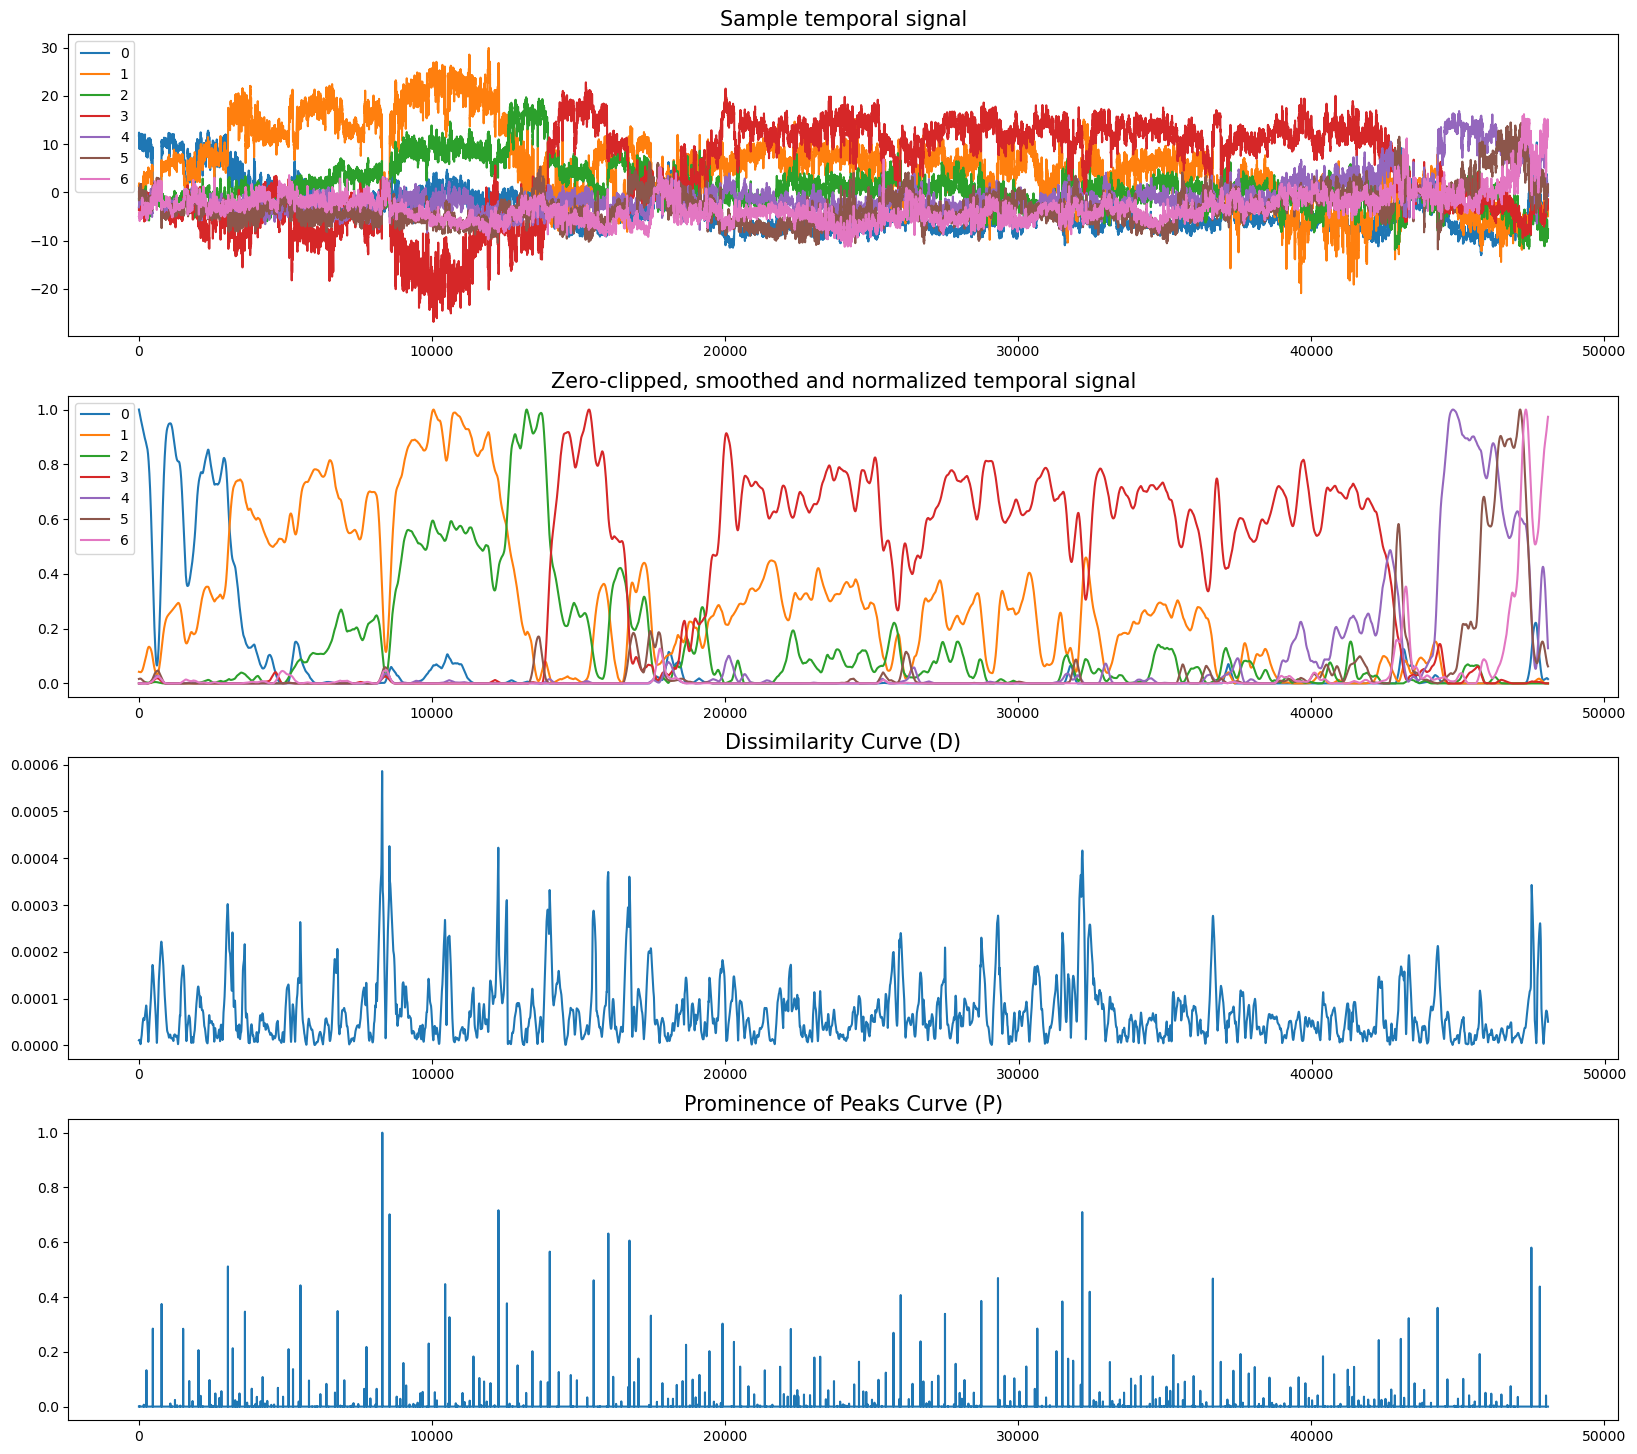

In [7]:
outputs_path="./tutorial_output/"
import numpy as np
with pd.ExcelWriter(outputs_path+"SSM_list.xlsx") as f:

    df = pd.DataFrame(index=txtfilename_list,columns=["SSM"])

    data_line=[]
    data_line2=[]
    data_line3=[]

    start_dx=1000
    initial_offset=0
    
    for idx in range(len(txtfilename_list)):

        input_name=txtfilename_list[idx]
        txtfilename1=txtfile_path+input_name

        pred_file = open(txtfilename1, 'r') 
        pred_Lines = pred_file.readlines()
        ts1=[]
        for i in pred_Lines:
            temp_array=[float(i.split(' ')[2].strip()), float(i.split(' ')[3].strip()), float(i.split(' ')[4].strip()), float(i.split(' ')[5].strip()), float(i.split(' ')[6].strip()), float(i.split(' ')[7].strip()), float(i.split(' ')[8].strip())]
            ts1.append(temp_array)
        ts2=np.array(ts1)
        ts3=np.copy(ts2)
        
        # negative clipped
        ts3[ts3<0] = 0
        ts4=np.copy(ts3)
        # class-wise smoothed using matched filter
        ts4_filt = utils.matched_filter(ts4, 200)
        # class-wise normalized
        for col in range(7):
            minimum=(min(ts4_filt[:,col]))
            ts4_filt[:,col]=ts4_filt[:,col]-minimum
            maximum=(max(ts4_filt[:,col]))
            ts4_filt[:,col]=ts4_filt[:,col]/maximum

        dissimilarities, change_point_scores = model.predict(ts4_filt)
        fig, ax = plt.subplots(4,figsize=(20,18))

        ax[0].plot(np.array(ts1),label=["0","1","2","3","4","5","6"])
        ax[0].legend(loc='upper left')
        ax[0].set_title('Sample temporal signal', size=15)
        
        ax[1].plot(ts4_filt,label=["0","1","2","3","4","5","6"])
        ax[1].legend(loc='upper left')
        ax[1].set_title('Zero-clipped, smoothed and normalized temporal signal', size=15)

        ax[2].plot(dissimilarities)
        ax[2].set_title('Dissimilarity Curve (D)', size=15)
        
        ax[3].plot(change_point_scores)
        ax[3].set_title('Prominence of Peaks Curve (P)', size=15)

        fig.savefig(outputs_path+input_name.split('.')[0], format='svg')
        
        # SSM calculation
        prom_count=len(change_point_scores[ np.where( change_point_scores > 0.1 ) ])
        factor2=1-(prom_count/(len(change_point_scores)/200))

        data_line2.append(round(factor2*20,2))
        
        print("Video ID: "+str(input_name.split('_')[2]))
        print("Surgical Skill Measure (SSM): "+str(round(factor2*20,2)))
        
    df.loc[:,"SSM"]=data_line2
    df.to_excel(f,sheet_name="Videoid_vs_SSM")